In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import math
import spyndex
# import earthpy as et
# import earthpy.spatial as es
# import earthpy.plot as ep




import glob
import os

# Import data/Test
Get help/tutorial from https://www.earthdatascience.org/courses/use-data-open-source-python/

### Import Landsat 8 data - VIS/NIR

In [2]:
path = "D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test"
data = sorted(glob.glob(path + "/*.TIF"))
data


['D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_QA_PIXEL.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_QA_RADSAT.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B1.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B2.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B3.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B4.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B5.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B6.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_B7.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/LS8_test\\LC08_L2SP_196025_20200919_20201006_02_T1_SR_QA

In [3]:
for i in range(2, 9):
    band_i = rxr.open_rasterio(data[i], masked = True).squeeze()
    band_corr = band_i*0.0000275-0.2
    globals()[f"band_{i-1}"] = band_corr


In [4]:
# Open QA_PIXEL Band --> obviously only zeros = no quality flags
QA_PIXEL = rxr.open_rasterio(data[1], masked = True).squeeze()

In [5]:
band_1.rio.nodata

In [6]:
band_1.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

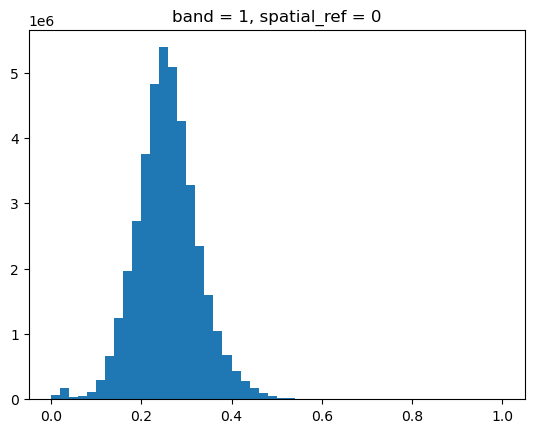

In [7]:
band_5.plot.hist(range=[0.0, 1.0], bins = 50)
plt.show()


In [8]:
print("Min:", np.nanmin(band_2.values))
print("Max:", np.nanmax(band_2.values))


Min: -0.19978
Max: 1.57485


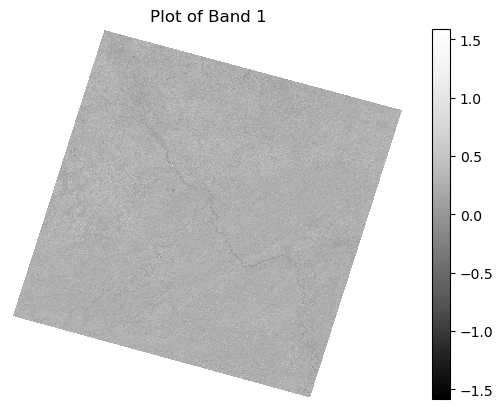

In [9]:
# Plot the data
f, ax=plt.subplots()
band_5.plot.imshow(ax=ax,
                  cmap="Greys_r")
ax.set_axis_off()
ax.set_title("Plot of Band 1")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


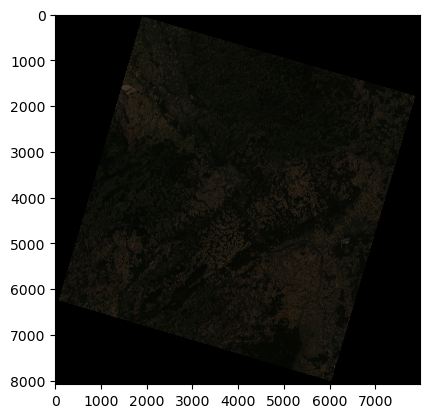

In [10]:
# Create RGB Plot
rgb = np.dstack((band_4, band_3, band_2))
plt.imshow(rgb)

### Import Landsat 8 data - Thermal

In [11]:
band_10 = rxr.open_rasterio(data[11], masked = True).squeeze()


In [12]:
band_10 = band_10*0.00341802+149

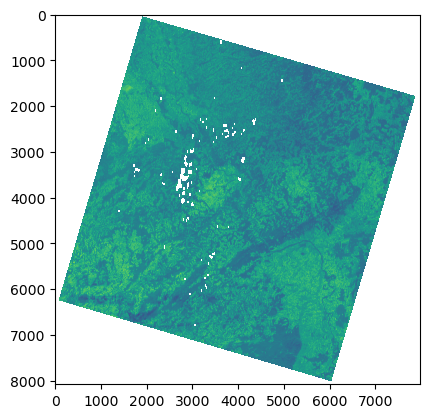

In [13]:
plt.imshow(band_10)

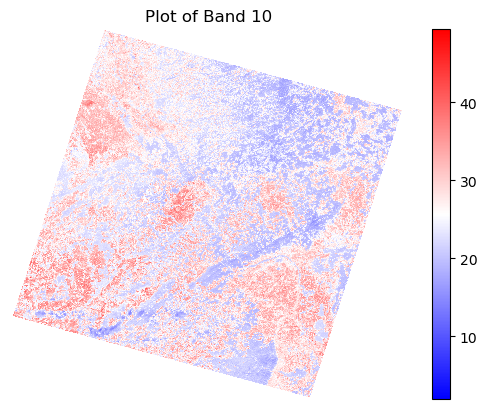

In [14]:
# T in Celsius
band_10_cels = band_10 - 273.15


# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 




# Plot the data
f, ax=plt.subplots()
band_10_cels.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band 10")
plt.show()

In [15]:
print("Min:", np.nanmin(band_10.values))
print("Max:", np.nanmax(band_10.values))


Min: 275.101
Max: 322.4987


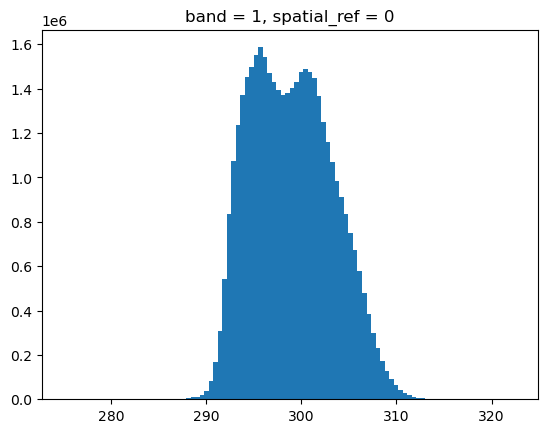

In [16]:
band_10.plot.hist(bins = 100)
plt.show()

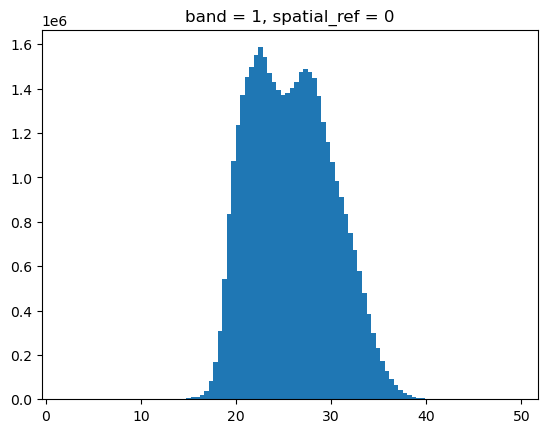

In [17]:
band_10_cels.plot.hist(bins = 100)
plt.show()

In [18]:
band_trad = rxr.open_rasterio(data[17], masked = True).squeeze()

In [19]:
band_trad = band_trad*0.001

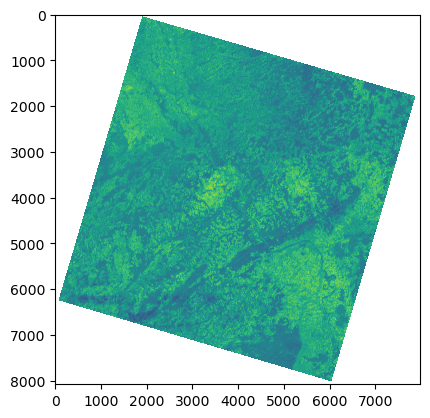

In [20]:
plt.imshow(band_trad)

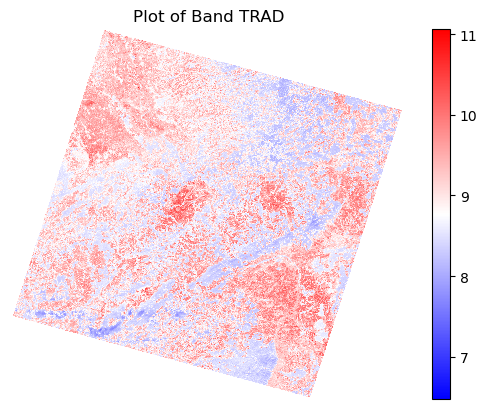

In [21]:
# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 




# Plot the data
f, ax=plt.subplots()
band_trad.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band TRAD")
plt.show()

# Processing Steps

## 1. Preprocessing

### 1. Satellite Data

### 2. Land Use Map

### 3. Meteorolocial Data

## 2. Surface Radiation Balance

### 2.1 NDVI, SAVI, LAI

In [22]:
# NDVI
# NDVI = (band_5 - band_4) / (band_5 + band_4)

NDVI = spyndex.computeIndex(
    index = "NDVI",
    params = {
        "N": band_5,
        "R": band_4
    }
)

In [23]:
# SAVI
# SAVI = (1+L_savi)*(band_5 - band_4) / (L_savi+band_5 + band_4)
L_savi = 0.5       # Value should be adjusted according to Soil Moisture (0.1 and 0.5 are suggested)

SAVI = spyndex.computeIndex(
    index = "SAVI",
    params = {
        "L": L_savi,
        "N": band_5,
        "R": band_4
    }
)

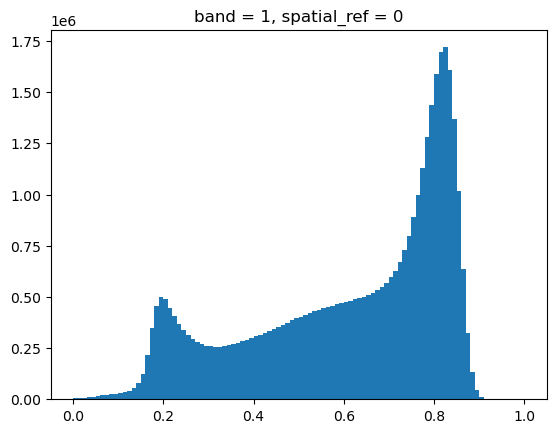

In [24]:
NDVI.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

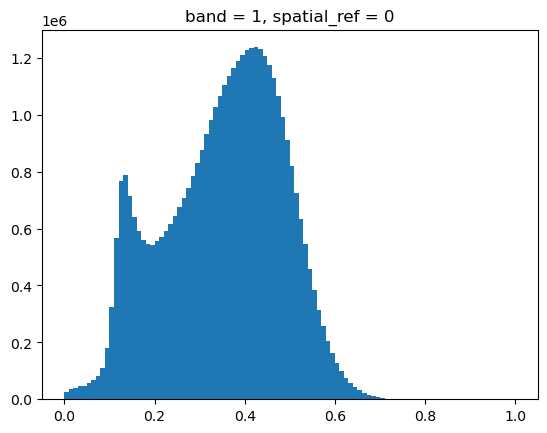

In [25]:
SAVI.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

In [26]:
# LAI
LAI = -(np.log((0.69-SAVI)/0.59)/0.91) 


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


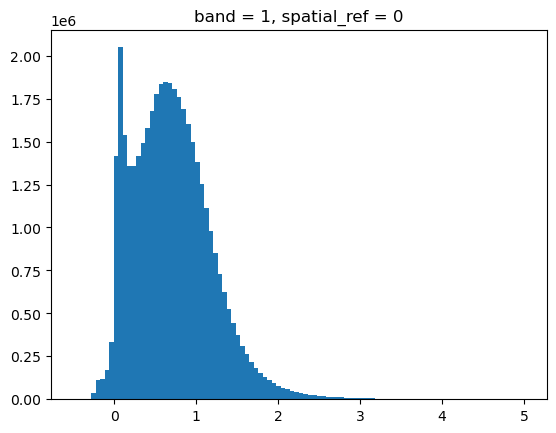

In [27]:
LAI.plot.hist(range=[-0.5, 5.0], bins = 100)
plt.show()

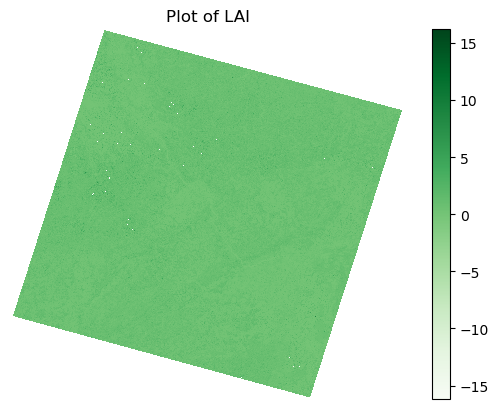

In [28]:
# Plot the data
f, ax=plt.subplots()
LAI.plot.imshow(ax=ax,
                  cmap = "Greens")
ax.set_axis_off()
ax.set_title("Plot of LAI")
plt.show()

### 2.2 Albedo
First Test Calculation from LS8 Reflectances based on https://yceo.yale.edu/how-convert-landsat-dns-albedo
Caution: intended for TOA, but here used with BOA-Reflectances

In [29]:
B1 = band_2     # Blue
B2 = band_4     # Red
B3 = band_5     # NIR 1 (0.76-0.9)
B4 = band_6     # NIR 2 (1.55-1.75)
B5 = band_7     # MIR (2.08-2.35)


albedo = ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) / 1.016

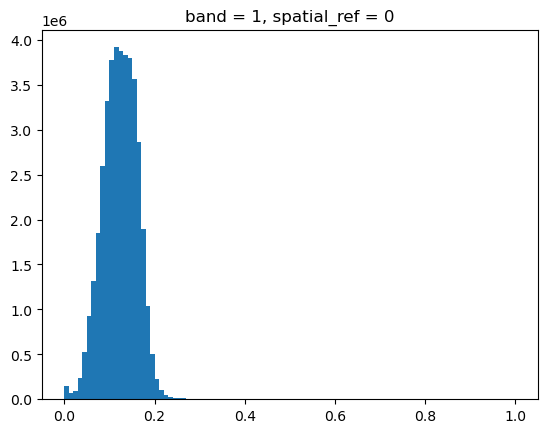

In [30]:
albedo.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

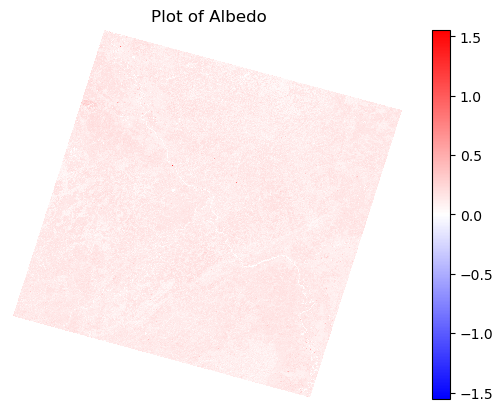

In [31]:
# Plot the data
f, ax=plt.subplots()
albedo.plot.imshow(ax=ax,
                  cmap = cmap)
ax.set_axis_off()
ax.set_title("Plot of Albedo")
plt.show()

### 2.3 Rs - Incoming Shortwave Radiation

In [32]:
# RS_incoming in W/m²

Gsc = 1367                  # Solar Constant in W/m²

# Solar Incidence Angle 
sun_elev = 39.24065277      # Sun elevation angle in degree, from Metadata_file
solar_inc = 90-sun_elev     # Solar Incidence Angle

# dr
DOY = 263                   # DOY of 19. September 2020
dr = 1+0.033*math.cos(DOY*(2*math.pi/365))  # relative sun-earth-distance dr 

# Atmospheric transmissivity
z = 104     # elevation above sea level (m) for Station (here: Bad Kreuznach elevation)     
tau_sw = 0.75+2*10**-5*z

# RS_incoming in W/m² (should be between 200 and 1000)
RS_in = Gsc * math.cos(solar_inc) * dr * tau_sw
RS_in

899.7472321021972

### 2.4 RL - Outgoing Longwave Radiation

Surface Emissivity (C, 2.), Thermal Radiance (C, 3.), Surface Temperature (C, 4.) are not needed at the moment because we already got Surface Temperature from Landsat Level 2


In [33]:
print("Max LAI:", np.nanmax(LAI.values))

Max LAI: 16.177588


In [34]:
emis_null = xr.where((LAI < 3) | LAI.isnull(), 0.95 + 0.01*LAI, 0.98)
emis_null

<xarray.DataArray (y: 8081, x: 7981)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 2.787e+05 2.787e+05 ... 5.181e+05 5.181e+05
  * y            (y) float64 5.692e+06 5.692e+06 ... 5.449e+06 5.449e+06
    spatial_ref  int32 0

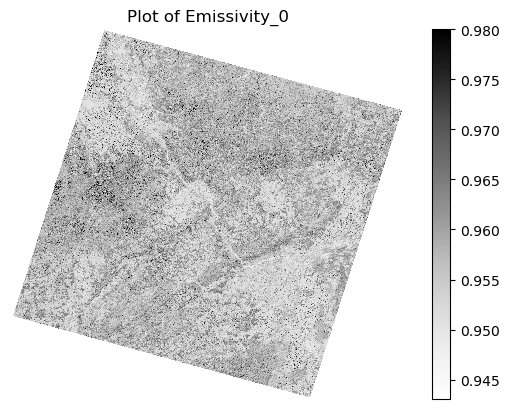

In [35]:
# Plot the data
f, ax=plt.subplots()
emis_null.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Emissivity_0")
plt.show()

In [36]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²
Ts = band_10    # Surface Temperature in Kelvin 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out = emis_null * sigma * Ts**4
RL_out

<xarray.DataArray (y: 8081, x: 7981)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 2.787e+05 2.787e+05 ... 5.181e+05 5.181e+05
  * y            (y) float64 5.692e+06 5.692e+06 ... 5.449e+06 5.449e+06
    spatial_ref  int32 0

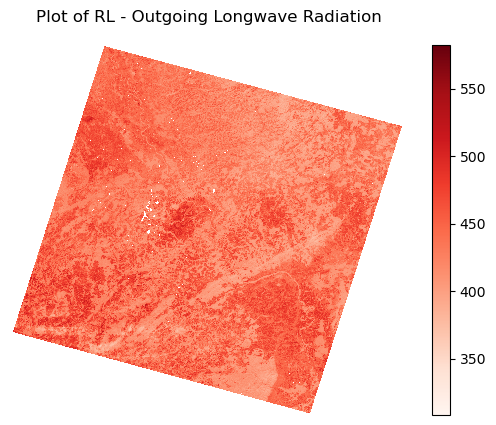

In [37]:
# Plot the data
f, ax=plt.subplots()
RL_out.plot.imshow(ax=ax,
                  cmap = "Reds")
ax.set_axis_off()
ax.set_title("Plot of RL - Outgoing Longwave Radiation")
plt.show()

### 2.5 RL - Incoming Longwave Radiation

In [38]:
# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
Tcold = 290             # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = Tcold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel)
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4
emis_atmo = 0.85 * (-np.log(tau_sw))**0.09  # Empirical Formula for Atmospheric Emissivity

RL_in = emis_atmo * sigma * Ta**4
RL_in

304.45143274489214

### 2.6 Solving vor Rn

In [39]:
# Solving for Net Surface Radiation Flux Rn
# typical Range: 100-700 W/m²
Rn = (1-albedo)*RS_in + RL_in - RL_out - (1-emis_null)*RL_in  # After SEBAL Manual

# Other Formula based on Allen 2007 / M.L. Fischer Script
# Rn_allen = RS_in - (albedo*RS_in) + RL_in - RL_out - (1-emis_null)*RL_in

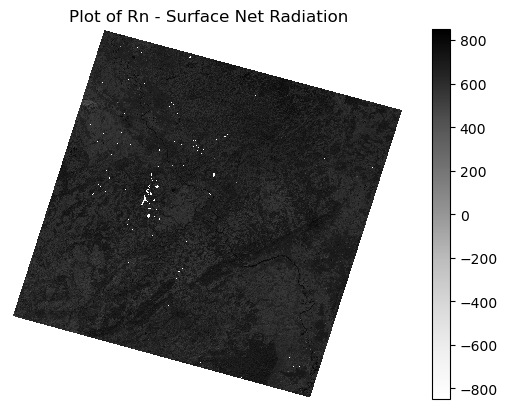

In [40]:
# Plot the data
f, ax=plt.subplots()
Rn.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Rn - Surface Net Radiation")
plt.show()

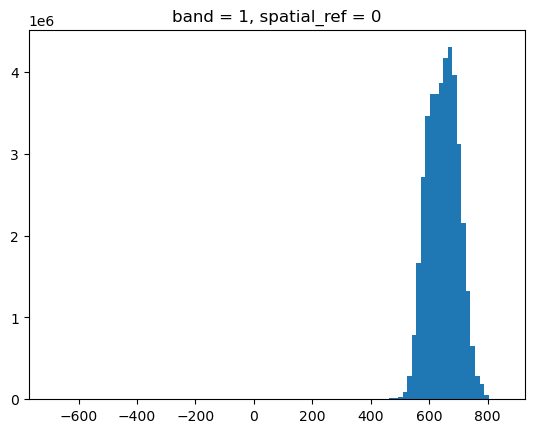

In [41]:
Rn.plot.hist(bins = 100)
plt.show()

## 3. Surface Energy Balance

### 3.1 G - Soil Heat Flux

In [42]:
# Soil Heat Flux
G_Rn_ratio = ((Ts-273.16)/albedo * ((0.0038*albedo)+(0.0075*(albedo**2)))*(1-0.98*(NDVI**4)))
G = G_Rn_ratio*Rn


print("Min:", np.nanmin(G_Rn_ratio.values))
print("Max:", np.nanmax(G_Rn_ratio.values))



Min: -3809089300.0
Max: 0.5335194


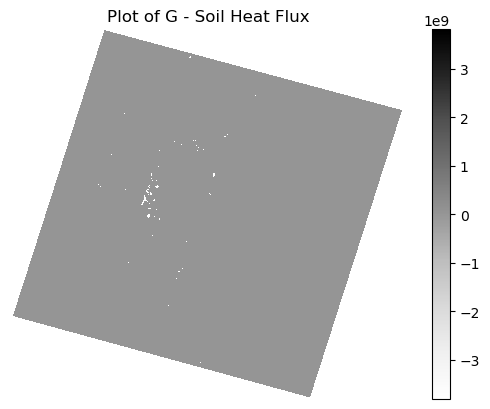

In [43]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

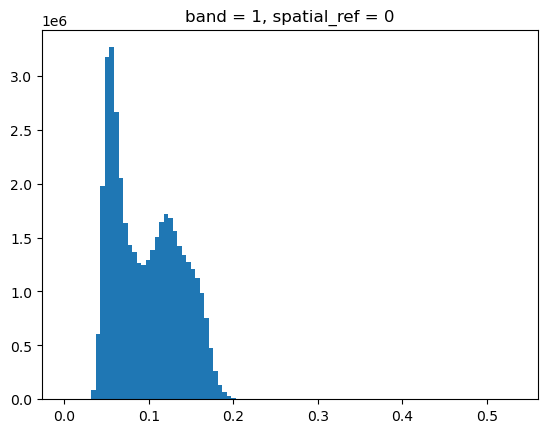

In [44]:
G_Rn_ratio_filt = G_Rn_ratio.where(G_Rn_ratio>0)
G_filt = G.where(G_Rn_ratio>0)

G_Rn_ratio_filt.plot.hist(bins = 100)
plt.show()

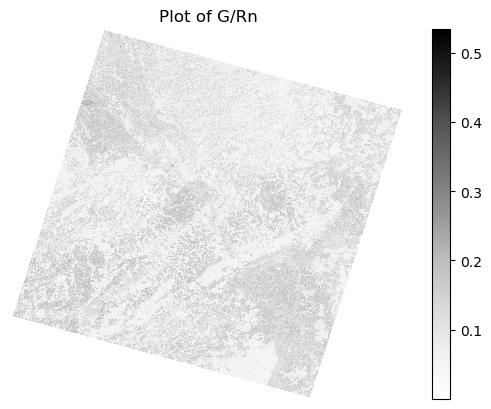

In [45]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G/Rn")
plt.show()

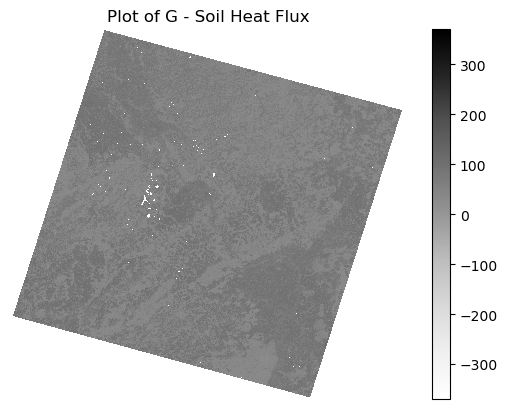

In [46]:
# Plot the data
f, ax=plt.subplots()
G_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

### 3.2 H - Sensible Heat Flux

#### 3.2.1 Aerodynamic Resistance r_ah

In [47]:
# r_ah for neutral stability
# Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
# Values are just assumed for testing, later taken from actual weather data according to the station
k = 0.41    # Karmans constant

ux = 20     # Wind speed at height zx (m/s)
zx = 2      # Height x with measured Wind speed ux
h_veg = 0.5      # Vegetation Heigh in m at weather station
zom_station = 0.12*h_veg   # momentum roughness length (m) at the weather station, SEBAL Manual suggests 0.12*height_vegetation


In [48]:
# 1. Friction veolocity u_asterix --> logaritmic wind profile
u_asterix = (k*ux) / (np.log(zx / zom_station))
u_asterix

2.338475576367114

In [49]:
# 2. Wind speed at 200m above ground u200
u200 = u_asterix * ((np.log(200/zom_station)) / k)
u200

46.26604391450525

In [50]:
# 3. Friction Velocity u_asterix_px for each Pixel 
#zom_px =  exp()          # Momentum roughness length (m) for each Pixel of the Image

#u_asterix_px = (k*u200) / (np.log(200 / zom_px))

# Assumed, simple variante (only for agriculture viable)
zom_px = 0.018 * LAI
u_asterix_px = (k*u200) / (np.log(200/zom_px))

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [51]:
# 4. Initial Aerodynamic resistance r_ah
z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

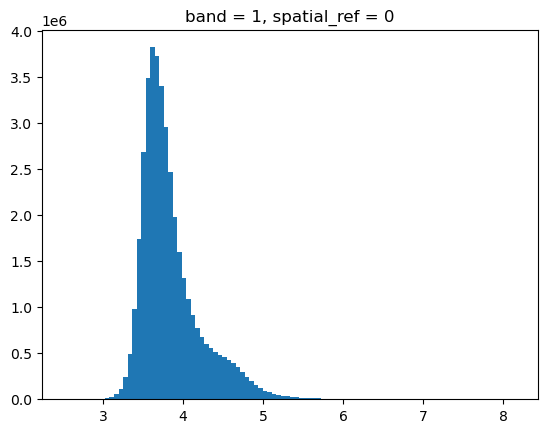

In [52]:
r_ah.plot.hist(bins = 100)
plt.show()

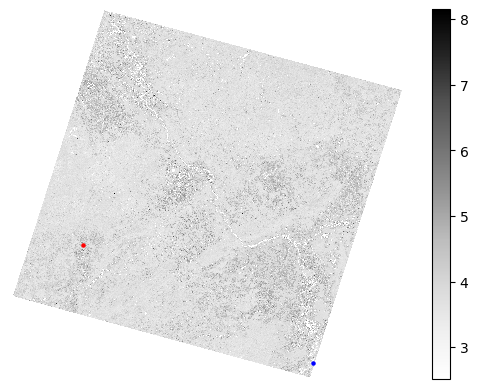

In [53]:
# Plot the data
f, ax=plt.subplots()
r_ah.plot.imshow(ax=ax,
                  cmap = "Greys")
plt.scatter([3.227e+05],[5.537e+06], color='red', s=5)
plt.scatter([4.616e+05],[5.46e+06], color='blue', s=5)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [54]:
# 5. Compute H from dT (near surface temperature difference)
# Compute H and dT for hot and cold anchor pixels

# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux

H_cold = 0
dT_cold = 0


# HOT PIXEL
H_hot = Rn - G
# Get r_ah for Hot Pixel after filtering r_ah non NAN
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
cp = 1004           # Air specific heat (J/kg/K)
dT_hot = H_hot * r_ah_hot / (roh_hot*cp)

In [55]:
# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Create Arrays for Linear Regression
Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
dT_linreg = np.array([dT_cold, dT_hot.item()])

# Build Linear Model
dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

# Extract Coefficients after dT = b + a*Ts
coeff_b = dT_model.intercept_
coeff_a = dT_model.coef_ 

In [56]:
# 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
dT_pix = coeff_b + coeff_a*Ts_nonan

In [57]:
# 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
Ta_pix = Ts_nonan - dT_pix

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

roh_pix = pressure / (Rs_constant * Ta_pix)

In [58]:
# 7. Calculate Sensible Heat Flux H with initial r_ah under neutral atmospheric conditions
H = (roh_pix * cp * dT_pix) / r_ah



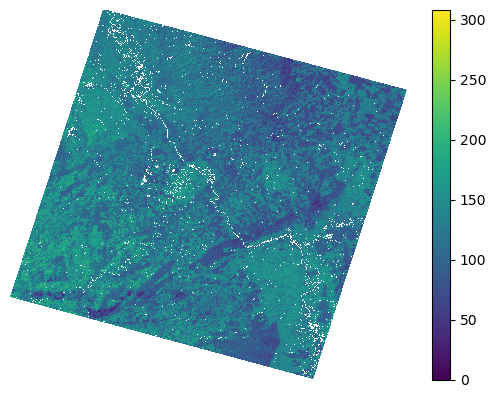

In [59]:
# Plot the data
f, ax=plt.subplots()
H.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [60]:
# 8. Stability correction/iteration
g = 9.81    # Gravitational constant, m/s²

# Monin-Obukhov Length L_mo
L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)




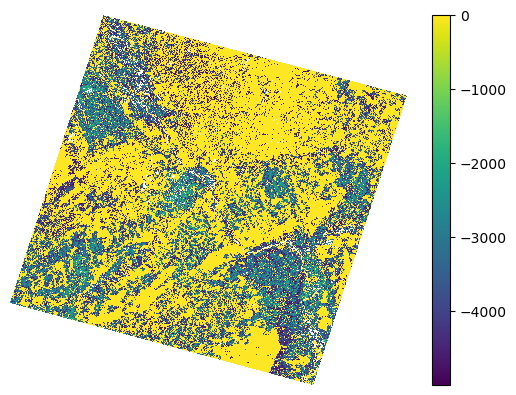

In [61]:
# Plot the data
data = L_mo > -5000
data = L_mo * data

f, ax=plt.subplots()
data.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [62]:
L_mo_filt = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
L_mo_filt

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

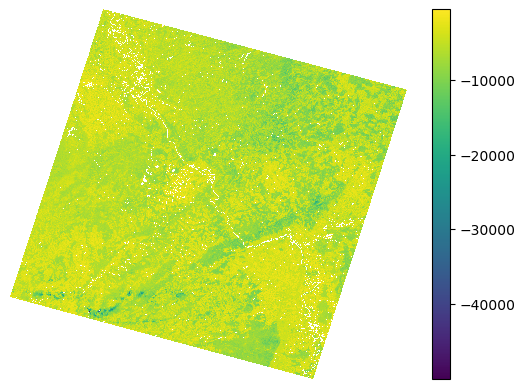

In [63]:
f, ax=plt.subplots()
L_mo_filt.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

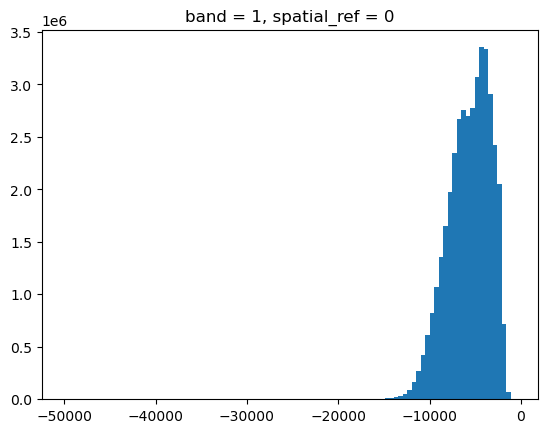

In [64]:
L_mo_filt.plot.hist(bins = 100)
plt.show()

In [65]:
# Coefficients for correction functions below
L_mo = L_mo_filt

x_200 = (1-(16*200/L_mo))**0.25
x_2 = (1-(16*2/L_mo))**0.25
x_01 = (1-(16*0.1/L_mo))**0.25

In [66]:
# Corections for momentum psi_m and heat transport psi_h 
# 1. Correction for psi_m_200

# if L_mo < 0
psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
# if L_mo > 0
psi_m_200_pos = -5*(2/L_mo)



psi_m_200 = L_mo    
psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

psi_m_200

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [67]:
x_val = 5200
y_val = 5200

print("L_mo =", L_mo[x_val, y_val])
print("psi_m_200_neg =", psi_m_200_neg[x_val, y_val])
print("psi_m_200_pos =", psi_m_200_pos[x_val, y_val])
print("psi_m_200 =", psi_m_200[x_val, y_val])

      

L_mo = <xarray.DataArray ()>
array(-2389.50684395)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_neg = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_pos = <xarray.DataArray ()>
array(0.00418496)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200 = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0


In [68]:
# Corections for momentum psi_m and heat transport psi_h 
# 2. Correction for psi_h_2

# if L_mo < 0
psi_h_2_neg = 2*np.log((1+x_2**2)/2)
# if L_mo > 0
psi_h_2_pos = -5*(2/L_mo)



psi_h_2 = L_mo    
psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 

psi_h_2

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [69]:
# Corections for momentum psi_m and heat transport psi_h 
# 3. Correction for psi_h_01

# if L_mo < 0
psi_h_01_neg = 2*np.log((1+x_01**2)/2)
# if L_mo > 0
psi_h_01_pos = -5*(0.1/L_mo)



psi_h_01 = L_mo    
psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 

psi_h_01

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

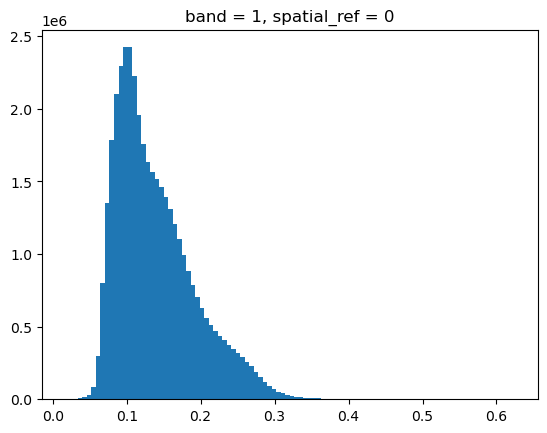

In [70]:
psi_m_200.plot.hist(bins = 100)
plt.show()

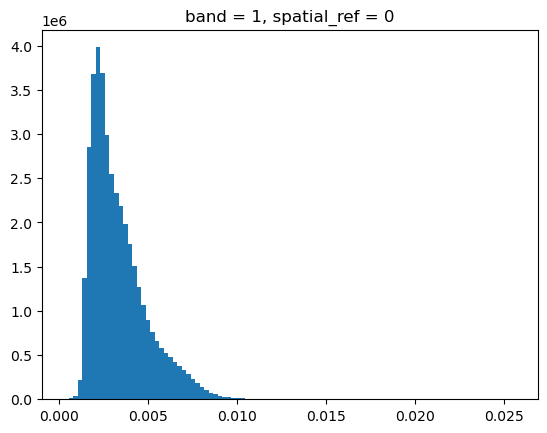

In [71]:
psi_h_2.plot.hist(bins = 100)
plt.show()

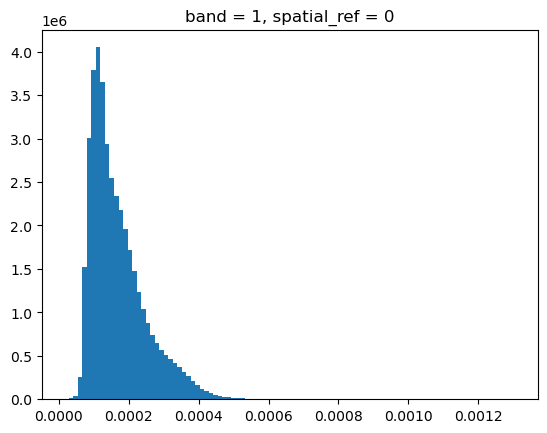

In [72]:
psi_h_01.plot.hist(bins = 100)
plt.show()

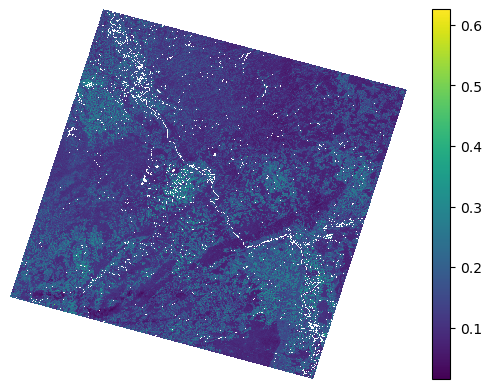

In [73]:
f, ax=plt.subplots()
psi_m_200.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

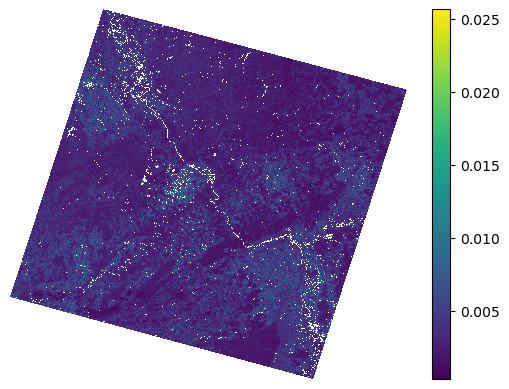

In [74]:
f, ax=plt.subplots()
psi_h_2.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

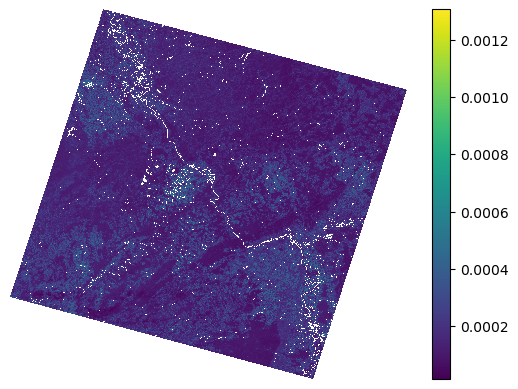

In [75]:
f, ax=plt.subplots()
psi_h_01.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


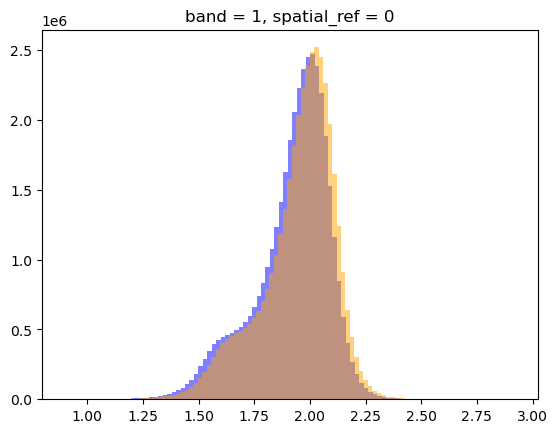

In [76]:
# 9. Calculate corrected Friction Velocity u_asterix_corr
u_asterix_corr = (k*u200) / (np.log(200/zom_px) - psi_m_200)

u_asterix_px.plot.hist(bins = 100, alpha = 0.5, color = "blue")
u_asterix_corr.plot.hist(bins = 100, alpha = 0.5, color = "orange")
plt.show()

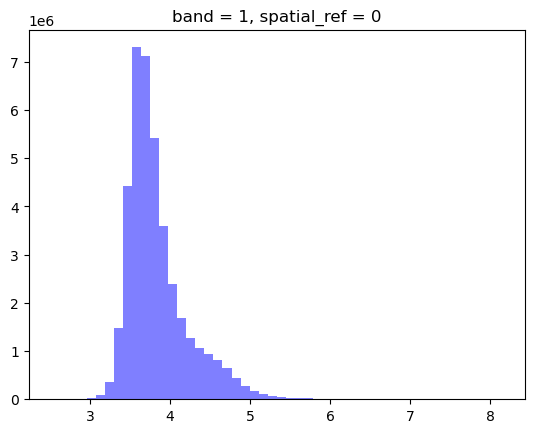

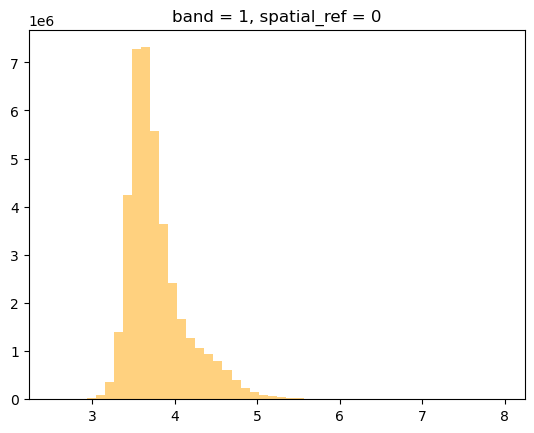

In [77]:
# 10. Corrected Areodynamic Resistance r_ah is calculated

# Initial r_ah:
# z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
# z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual
# r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

# Corrected r_ah_corr
r_ah_corr = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_corr * k)

r_ah.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

r_ah_corr.plot.hist(bins = 50, alpha = 0.5, color = "orange")
plt.show()

In [81]:
# 11. Add all steps into for loop
# Outside Loop
# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux
H_cold = 0
dT_cold = 0

# HOT PIXEL
H_hot = Rn - G
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)

# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop
for i in range(15):
    # 5. Compute H from dT (near surface temperature difference)
    # Compute H and dT for hot and cold anchor pixels
    
    # Get r_ah for Hot Pixel after filtering r_ah non NAN
    r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
    dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # 5.1 Linear Regression on T against dT --> get coeffiients b and a
    # Create Arrays for Linear Regression
    Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
    dT_linreg = np.array([dT_cold, dT_hot.item()])

    # Build Linear Model
    dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

    # Extract Coefficients after dT = b + a*Ts
    coeff_b = dT_model.intercept_
    coeff_a = dT_model.coef_ 
    
    # 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
    dT_pix = coeff_b + coeff_a*Ts_nonan
    
    # 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
    Ta_pix = Ts_nonan - dT_pix

    roh_pix = pressure / (Rs_constant * Ta_pix)

    # 7. Calculate Sensible Heat Flux H with updated r_ah
    H = (roh_pix * cp * dT_pix) / r_ah
    
    # 8. Stability correction/iteration
    # Monin-Obukhov Length L_mo
    L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)
    
    # Filter -inf values
    L_mo_ = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
    
    # Coefficients for Corrections functions below
    x_200 = (1-(16*200/L_mo))**0.25
    x_2 = (1-(16*2/L_mo))**0.25
    x_01 = (1-(16*0.1/L_mo))**0.25

    #####################################
    # Corections for momentum psi_m and heat transport psi_h 
    #####################################
    # 1. Correction for psi_m_200
    #####################################
    # if L_mo < 0
    psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
    # if L_mo > 0
    psi_m_200_pos = -5*(2/L_mo)

    psi_m_200 = L_mo    
    psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
    psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

    #####################################
    # 2. Correction for psi_h_2
    #####################################
    # if L_mo < 0
    psi_h_2_neg = 2*np.log((1+x_2**2)/2)
    # if L_mo > 0
    psi_h_2_pos = -5*(2/L_mo)

    psi_h_2 = L_mo    
    psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
    psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 
    
    #####################################
    # 3. Correction for psi_h_01
    #####################################
    # if L_mo < 0
    psi_h_01_neg = 2*np.log((1+x_01**2)/2)
    # if L_mo > 0
    psi_h_01_pos = -5*(0.1/L_mo)

    psi_h_01 = L_mo    
    psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
    psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 
    
    #####################################
    
    # 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix_px / 
    u_asterix_px = (k*u200) / (np.log(200/zom_px) - psi_m_200)
    
    # 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
    r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_px * k)
    
    # Save values to Stability Correction DataFrame
    df_stabcorr.loc[i].Iteration = i
    df_stabcorr.loc[i].r_ah_hot = r_ah_hot
    df_stabcorr.loc[i].dT_hot = dT_hot
    


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:76

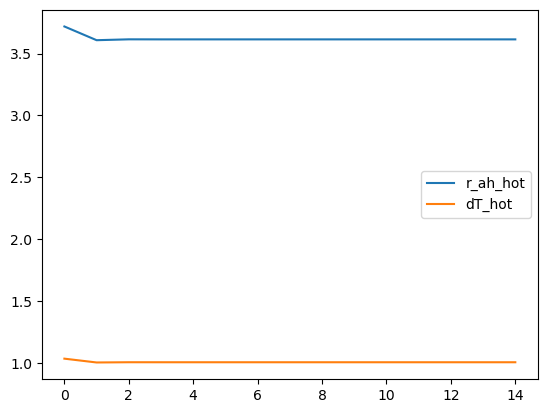

In [131]:
# Plot Change in Stability correction values
plt.plot(df_stabcorr.r_ah_hot, label = df_stabcorr.columns[1])
plt.plot(df_stabcorr.dT_hot, label = df_stabcorr.columns[2])
plt.legend()
plt.show()

In [128]:
df_stabcorr.columns[1]

'r_ah_hot'

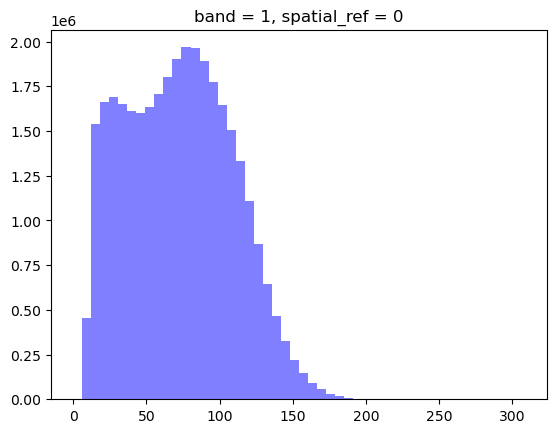

In [ ]:
H.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

### 3.3 ET - Latent Heat Flux

In [ ]:
# Quick and Dirty Calculation of ET (to this point without iterative correction)
ETL = Rn - G_filt - H
ETL = ETL.where(ETL>=0)


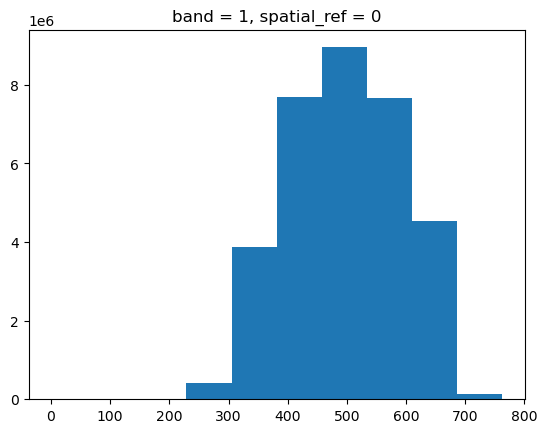

In [ ]:
ETL.plot.hist()
plt.show()

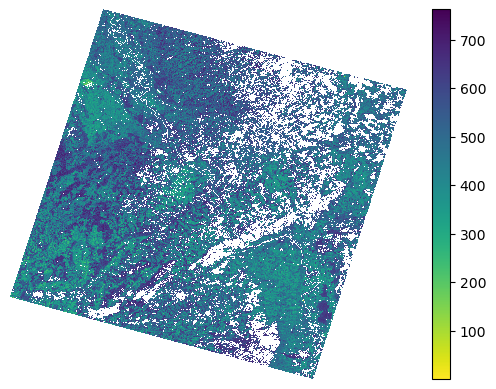

In [ ]:
# Plot the data
f, ax=plt.subplots()
ETL.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

(array([4.600000e+02, 3.067000e+03, 4.376700e+04, 1.279162e+06,
        7.165103e+06, 9.844084e+06, 9.113592e+06, 9.385700e+06,
        2.863758e+06, 9.550400e+04]),
 array([9.27701286e-04, 1.20478762e-01, 2.40029823e-01, 3.59580883e-01,
        4.79131944e-01, 5.98683005e-01, 7.18234066e-01, 8.37785126e-01,
        9.57336187e-01, 1.07688725e+00, 1.19643831e+00]),
 <BarContainer object of 10 artists>)

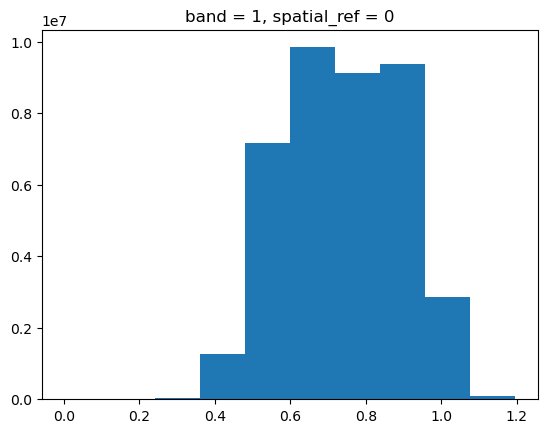

In [ ]:
# From ET_lambda to ET in mm/hour
lamda = 2.25 * 10**6 # Latet heat of Vaporization J/kg
ET_inst = 3600* (ETL / lamda)

ET_inst.plot.hist()

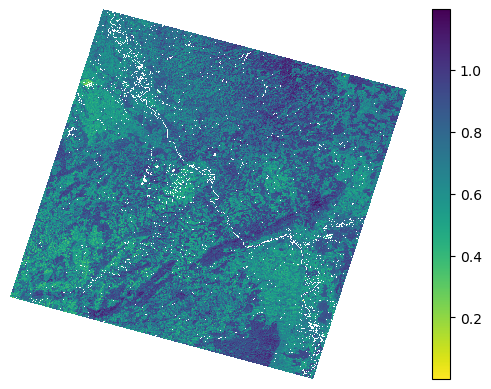

In [ ]:
# Plot the data
f, ax=plt.subplots()
ET_inst.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()